# SommAI

### Wine recommender based on NLP

### Dataset: professional wine reviews scraped from WineEnthusiast available on Kaggle:
WineEnthusiast source: https://www.winemag.com/?s=&drink_type=wine

KAGGLE source: https://www.kaggle.com/zynicide/wine-reviews

### Extra info:
WineFolly: https://winefolly.com/

#### Author: Bruna Correa

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from wordcloud import WordCloud 
from nltk.corpus import stopwords
import string
import re
from nltk import WordNetLemmatizer
from scipy.stats import kendalltau

from gensim.models.phrases import Phrases, Phraser
from collections import Counter, OrderedDict

# Image mask wordcloud
from PIL import Image

# Multilabel Binarizer
from sklearn.preprocessing import MultiLabelBinarizer

# KNN recommendation
from sklearn.neighbors import NearestNeighbors

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Extra downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set sns style
sns.set(style="ticks", color_codes=True)

# Plots main color
my_col = 'maroon'

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# Load dataset
wine_df = pd.read_csv("/data/winemag-data-130k-v2.csv", index_col=0)
print(f'Total number of reviews: {wine_df.shape[0]}')
wine_df.head()

Total number of reviews: 129971


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Columns info
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [4]:
# Describe numerical columns
wine_df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


## Step1: Pre-processing and feature engineering

In [5]:
# Create new column with vintage year

# Define function to get vintage year
def get_vintage(input_df):
    vintage_col = []
    #year = int()
    for title in input_df['title'].str.split():
        year = []
        for word in title:
            if word.isdigit() and (1929 < int(word) < 2020):
                year.append(int(word))
        if len(year) > 0:
            vintage_col.append(max(year))
        else:
            vintage_col.append(None)        
    return vintage_col

# Add column with vintage year to wine dataFrame
wine_df['vintage'] = get_vintage(wine_df)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [6]:
# Describe vintage column
wine_df.describe()

,points,price,vintage
count,129971.000000,120975.000000,125341.000000
mean,88.447138,35.363389,2010.684469
std,3.039730,41.022218,3.635079
min,80.000000,4.000000,1934.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,25.000000,2011.000000
75%,91.000000,42.000000,2013.000000
max,100.000000,3300.000000,2017.000000


In [7]:
# Check for missing values
pd.set_option("display.max_rows", None)
wine_df.isnull().mean().sort_values()

description              0.000000
points                   0.000000
title                    0.000000
winery                   0.000000
variety                  0.000008
country                  0.000485
province                 0.000485
vintage                  0.035623
price                    0.069215
region_1                 0.163475
taster_name              0.201922
taster_twitter_handle    0.240154
designation              0.288257
region_2                 0.611367
dtype: float64

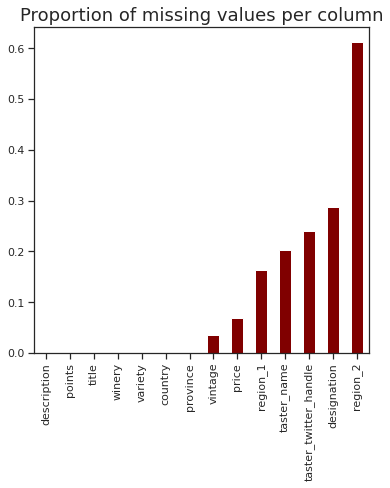

In [8]:
# Plot missing values
wine_df.isnull().mean().sort_values().plot(kind='bar', 
                                           color=my_col, 
                                           figsize=(6, 6))
plt.title('Proportion of missing values per column', size=18)
plt.show()

In [9]:
# Exclude missing values in: ['price', 'country', 'province', 'variety', 'vintage']
cols_to_drop = ['price', 'country', 'province', 'variety', 'vintage']
wine_df = wine_df.dropna(subset=cols_to_drop).reset_index(drop=True)

print(f'Total number of reviews after excluding missing values: {wine_df.shape[0]}')

Total number of reviews after excluding missing values: 116761


In [10]:
# Drop duplicated wine titles
wine_df = wine_df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)

print(f'Total number of reviews after excluding duplicated wines: {wine_df.shape[0]}')

Total number of reviews after excluding duplicated wines: 107342


In [11]:
# Convert vintage year to integer
wine_df['vintage'] = wine_df['vintage'].astype(int)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
2,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
3,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [12]:
# Check wine varieties names
pd.set_option("display.max_rows", None)
wine_df['variety'].value_counts(normalize=True).to_frame()

,variety
Pinot Noir,0.108485
Chardonnay,0.092815
Cabernet Sauvignon,0.081273
Red Blend,0.070578
Bordeaux-style Red Blend,0.045546
Riesling,0.042248
Sauvignon Blanc,0.040636
Syrah,0.035112
Rosé,0.027128
Merlot,0.026383


In [13]:
# Consolidating wine varieties
# Some wines have different variety spelling (and mispellings)

# Build a dictionaty to consolidate varieties
variety_dict = {'Pinot Nero': 'Pinot Noir',
                'Pinot Gris': 'Pinot Grigio', 
                'Pinot Grigio/Gris': 'Pinot Grigio',
                'Pinot Bianco': 'Pinot Blanc',
                'Shiraz': 'Syrah',
                'Garnacha, Grenache': 'Grenache', 
                'Garnacha': 'Grenache',
                'Garnacha Blanca': 'Grenache Blanc',
                'Alvarinho': 'Albariño',
                'Rosado': 'Rosé', 
                'Rosato': 'Rosé',
                'Monastrell': 'Mourvèdre',
                'Moscato': 'Muscat'
                }

# Define function to consolidate variety names
def get_consol_var(variety):
    if variety in variety_dict:
        return variety_dict[variety]
    else:
        return variety

# Consolidate 
wine_df['variety'] = wine_df['variety'].apply(get_consol_var)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
1,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Grigio,Rainstorm,2013
2,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
3,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [14]:
# Get wines varieties with at least 50 reviews
wine_min_50 = wine_df['variety'].value_counts().loc[lambda x : x >= 50]

# Filter wine varieties with at least 50 reviews
wine_filter = list(wine_min_50.index)
wine_df = wine_df[wine_df['variety'].isin(wine_filter)]

print(f'Total number of reviews after excluding less represented wine varieties: {wine_df.shape[0]}')

Total number of reviews after excluding less represented wine varieties: 102783


In [15]:
# Filter mispriced wines
# Manual inspection of wines > $1000
# 'Château les Ormes Sorbet 2013 Médoc'
# 'Blair 2013 Roger Rose Vineyard Chardonnay (Arroyo Seco)'
# 'Emmerich Knoll 2013 Ried Loibenberg Smaragd Grüner Veltliner (Wachau)'

# Manual check
wine_df[wine_df['price'] > 1000]

# Get indexes
wines_to_filter = [68271, 99950, 75756]

# Filter out mispriced wines
wine_df = wine_df[~wine_df.index.isin(wines_to_filter)].reset_index(drop=True)

print(f'Total number of reviews after filtering: {wine_df.shape[0]}')

Total number of reviews after filtering: 102780


In [16]:
# Check price filtered df
wine_df.describe()

,points,price,vintage
count,102780.000000,102780.000000,102780.000000
mean,88.474820,36.060090,2010.622465
std,3.109201,40.750386,3.696810
min,80.000000,4.000000,1935.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,26.000000,2011.000000
75%,91.000000,44.000000,2013.000000
max,100.000000,2500.000000,2017.000000


In [17]:
wine_df[wine_df['price'] > 1000]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
1329,France,"A massive wine for Margaux, packed with tannin...",NaN,98,1900.0,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux,2009
1337,France,"Such a generous and ripe wine, with a dark cor...",NaN,97,1100.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château La Mission Haut-Brion 2009 Pessac-Léo...,Bordeaux-style Red Blend,Château La Mission Haut-Brion,2009
1342,France,"Solid, very structured, packed with dense and ...",NaN,96,1200.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Haut-Brion 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Haut-Brion,2009
1345,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,96,1300.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,2009
13507,France,The wine is a velvet glove in an iron fist. Th...,NaN,96,2500.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2014
53691,France,This extravagantly perfumed wine has great jui...,NaN,97,2000.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2011
79308,France,"A superb wine from a great year, this is power...",NaN,96,2500.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2010
89362,France,"Almost black in color, this stunning wine is g...",NaN,100,1500.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild,2010
89364,France,This is the finest Cheval Blanc for many years...,NaN,100,1500.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Cheval Blanc 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Cheval Blanc,2010
90634,France,"A wonderfully complete wine, with all the elem...",NaN,96,2000.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2005


## Step2: EDA

In [18]:
# How many wine varieties/blends?
print(f'In total, there are {len(set(wine_df.variety))} different wines varieties/blends in the dataset.')

In total, there are 106 different wines varieties/blends in the dataset.


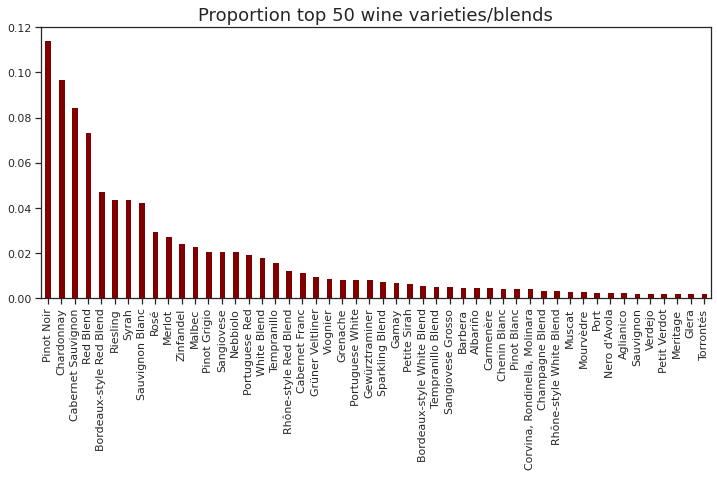

In [19]:
# Plot most popular (top 50) wine varieties/blends
wine_df['variety'].value_counts(normalize=True)[0:50].plot(kind='bar', 
                                                           color=my_col,
                                                           figsize=(12, 5),
                                                          )
plt.title('Proportion top 50 wine varieties/blends', size=18)
plt.show()

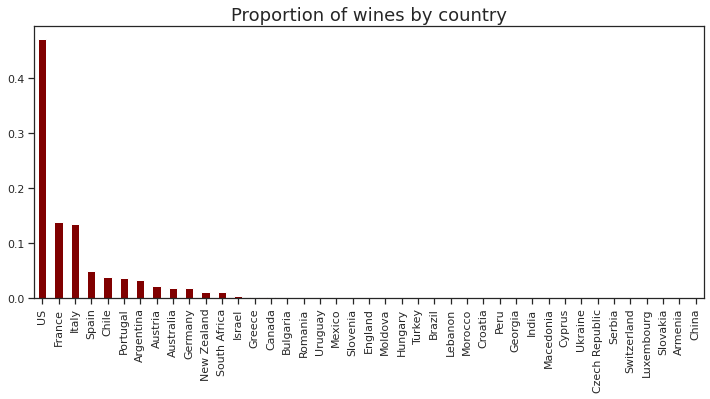

In [20]:
# Plot most popular (top 50) wine varieties
wine_df['country'].value_counts(normalize=True).plot(kind='bar', 
                                       color=my_col,
                                       figsize=(12, 5)
                                      )
plt.title('Proportion of wines by country', size=18)
plt.show()

In [21]:
# Proportion table
# Check wine varieties names
wine_df['country'].value_counts(normalize=True).to_frame()

,country
US,0.470558
France,0.138334
Italy,0.134112
Spain,0.049329
Chile,0.038782
Portugal,0.037410
Argentina,0.032857
Austria,0.022641
Australia,0.019216
Germany,0.017786


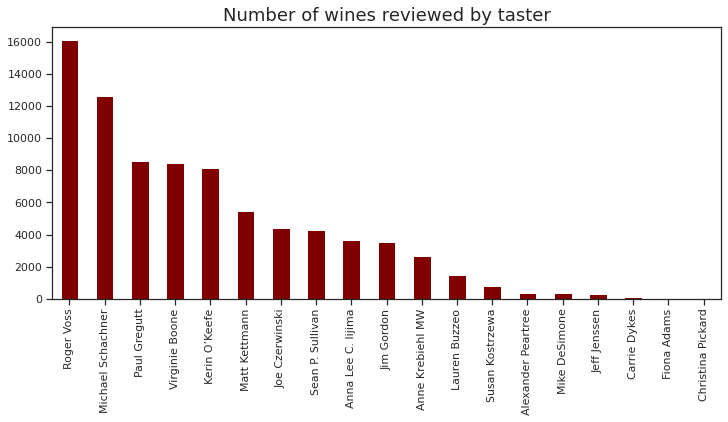

In [22]:
# Number of reviwes per reviwer
wine_df['taster_name'].value_counts(normalize=False).plot(kind='bar', 
                                       color=my_col,
                                       figsize=(12, 5)
                                      )
plt.title('Number of wines reviewed by taster', size=18)
plt.show()

### Price stats

In [23]:
# Stats of wine price per country
wine_df.groupby(['country'])['price'].describe().sort_values('50%', ascending=False)

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Switzerland,4.0,94.750000,75.663179,21.0,33.75,99.0,160.00,160.0
England,47.0,53.829787,16.291261,25.0,43.00,50.0,62.50,95.0
Serbia,4.0,31.000000,11.604597,20.0,21.50,31.0,40.50,42.0
Canada,211.0,35.568720,20.041356,12.0,20.50,30.0,40.50,120.0
Italy,13784.0,41.827989,40.168479,5.0,19.00,30.0,52.00,900.0
US,48364.0,37.082003,26.284561,4.0,20.00,30.0,45.00,750.0
Germany,1828.0,44.418490,66.548207,5.0,18.00,28.0,45.00,775.0
Austria,2327.0,30.996992,18.546112,9.0,18.00,25.0,39.00,160.0
Israel,422.0,31.808057,19.165082,8.0,18.00,25.0,40.00,150.0


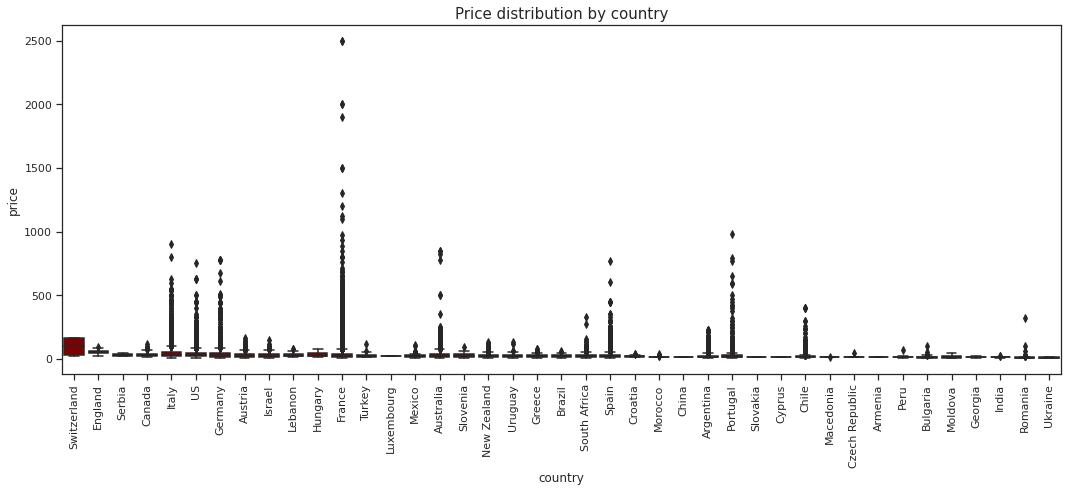

In [24]:
# Order price by mean to plot
sort_price_median = wine_df.groupby(['country'])['price'].aggregate(np.median).reset_index().sort_values('price', 
                                                                                              ascending=False)

# Wine price by country
plt.figure(figsize=(15, 7))
sns.boxplot(y='price', 
            x='country',
            data=wine_df,
            order=sort_price_median['country'],
            color=my_col,
            saturation=1)
plt.title('Price distribution by country', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

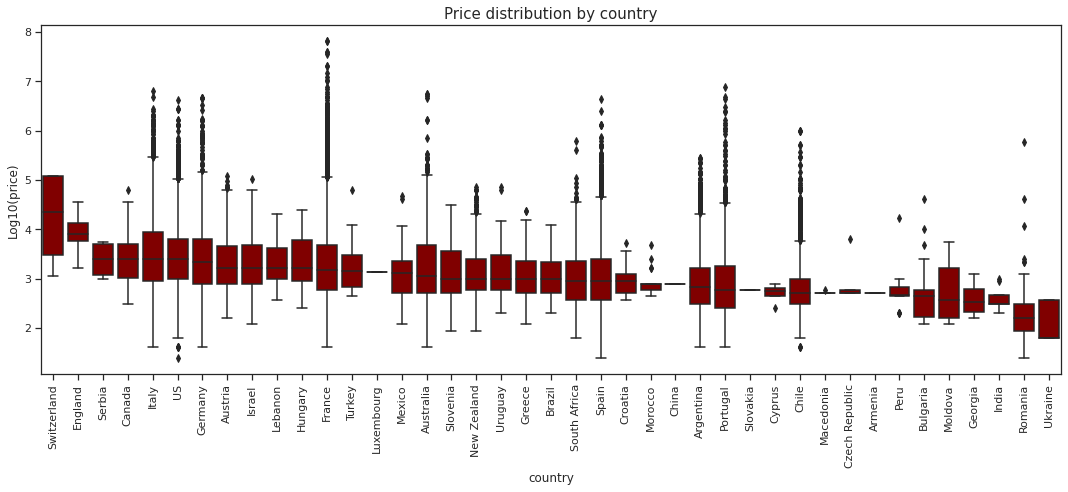

In [25]:
# Create Log10 price column
wine_df['log10_price'] = np.log(wine_df['price'])

# Wine price by country
plt.figure(figsize=(15, 7))
sns.boxplot(y='log10_price', 
            x='country',
            data=wine_df,
            order=sort_price_median['country'],
            color=my_col,
            saturation=1)
plt.title('Price distribution by country', fontsize=15)
plt.ylabel('Log10(price)')
plt.xticks(rotation='vertical')
plt.tight_layout()

In [26]:
# Stats of wine price per province
wine_df.groupby(['province'])['price'].describe().sort_values('50%',
                                                             ascending=False)

,count,mean,std,min,25%,50%,75%,max
province,,,,,,,,
Madeira,1.0,220.000000,NaN,220.0,220.00,220.0,220.00,220.0
Vânju Mare,2.0,166.000000,217.788889,12.0,89.00,166.0,243.00,320.0
Switzerland,2.0,160.000000,0.000000,160.0,160.00,160.0,160.00,160.0
Puente Alto,14.0,84.500000,41.185789,21.0,54.75,95.0,115.75,150.0
Santa Cruz,6.0,77.500000,29.283101,35.0,57.50,95.0,95.00,100.0
Champagne,433.0,116.609700,90.077732,30.0,66.00,86.0,135.00,800.0
Haut-Judeé,4.0,66.250000,14.361407,45.0,63.75,72.5,75.00,75.0
Franken,9.0,88.555556,100.457841,20.0,42.00,65.0,80.00,350.0
Port,243.0,86.876543,125.446513,13.0,30.00,60.0,80.00,980.0


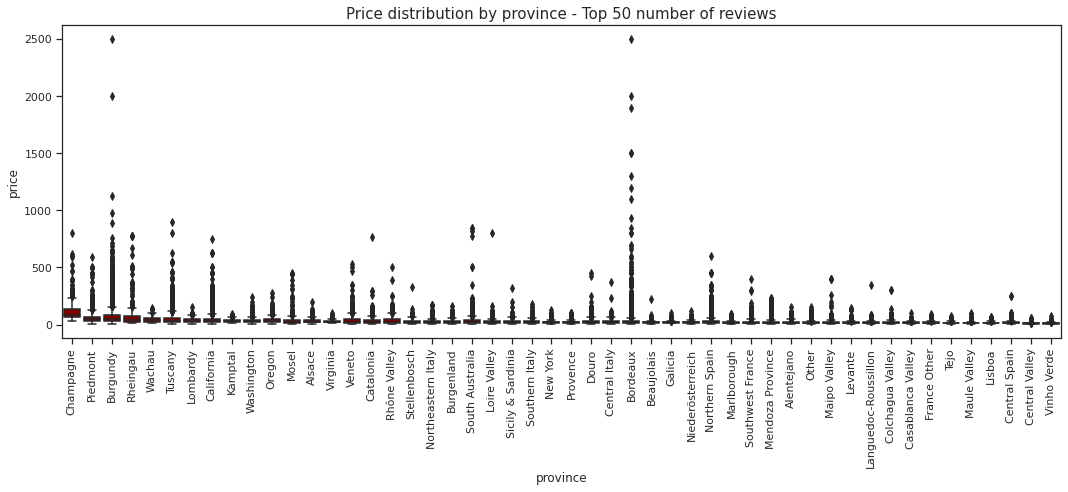

In [27]:
# Get top 50 provinces with more reviews
sort_count_prov = wine_df.groupby(['province'])['price'].describe().sort_values('count',
                                                                          ascending=False)
count_prov_top50 = list(sort_count_prov[0:50].index)
wine_df_prov_top50 = wine_df[wine_df['province'].isin(count_prov_top50)]

# Order price by mean to plot
sort_price_mean_prov = wine_df_prov_top50.groupby(['province'])['price'].aggregate(np.median).reset_index().sort_values('price', 
                                                                                              ascending=False)
# Wine price by province (Top 50)
plt.figure(figsize=(15, 7))
sns.boxplot(y='price', 
            x='province',
            data=wine_df_prov_top50,
            order=sort_price_mean_prov['province'],
            color=my_col,
            saturation=1)
plt.title('Price distribution by province - Top 50 number of reviews', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

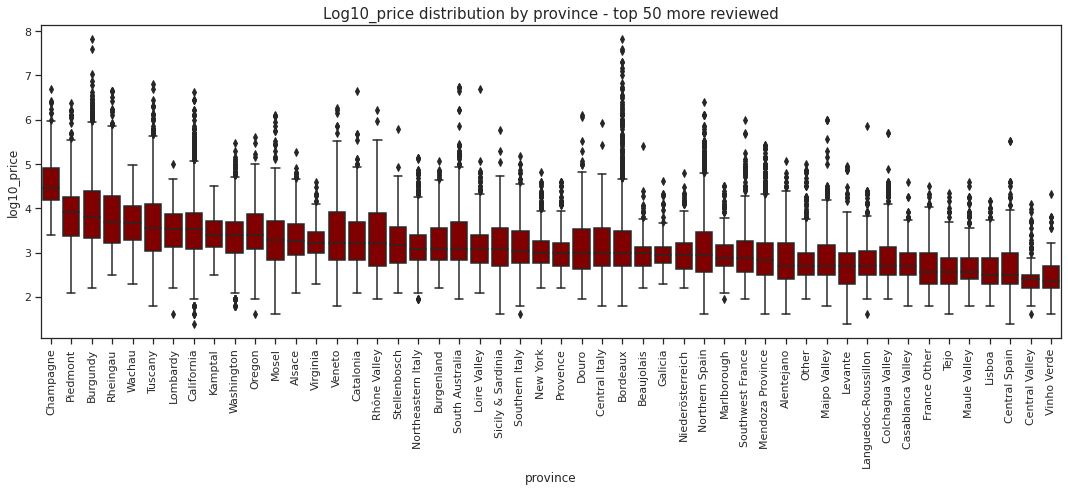

In [28]:
# Log10 Price - Wine price by province
# Wine price by province (Top 50)
plt.figure(figsize=(15, 7))
sns.boxplot(y='log10_price', 
            x='province',
            data=wine_df_prov_top50,
            order=sort_price_mean_prov['province'],
            color=my_col,
            saturation=1)
plt.title('Log10_price distribution by province - top 50 more reviewed', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [29]:
# Stats of wine price per variety
pd.set_option("display.max_rows", None)

# Most expensive varieties
wine_exp = wine_df.groupby(['variety'])['price'].describe().sort_values('50%',
                                                             ascending=False)
wine_exp

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Champagne Blend,405.0,97.972840,79.491588,12.0,50.00,75.0,120.00,600.0
Sangiovese Grosso,545.0,65.319266,48.339951,12.0,45.00,60.0,75.00,900.0
Nebbiolo,2154.0,66.324048,43.947398,12.0,44.00,57.0,78.00,595.0
Port,291.0,78.955326,116.151334,12.0,30.00,52.0,75.00,980.0
Sagrantino,88.0,53.363636,20.995447,21.0,39.75,50.0,60.00,119.0
Spätburgunder,65.0,60.753846,36.032984,16.0,33.00,50.0,80.00,181.0
Pinot Noir,11771.0,47.958202,49.155766,5.0,28.00,42.0,55.00,2500.0
Cabernet Blend,75.0,51.106667,39.907181,9.0,22.50,40.0,72.50,260.0
Cabernet Sauvignon,8724.0,48.375974,41.659592,4.0,20.00,38.0,65.00,625.0


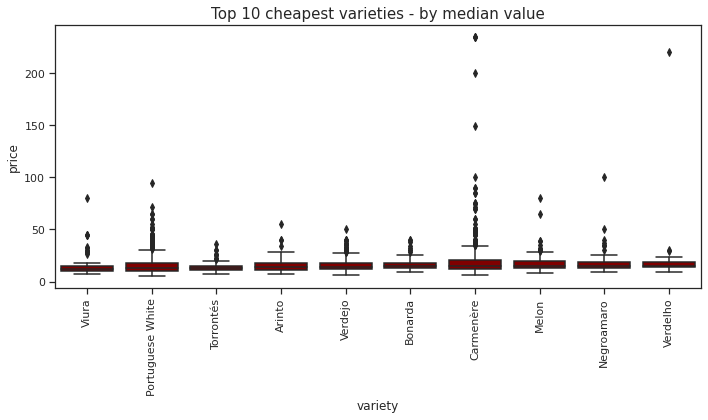

In [30]:
# Cheapest varieties - by median
wine_cheap = wine_df.groupby(['variety'])['price'].describe().sort_values('50%',
                                                                          ascending=True)

# Plot top 10 less expensive

# Filter top 10
cheap_var = list(wine_cheap[0:10].index)
wine_df_cheap = wine_df[wine_df['variety'].isin(cheap_var)]

# Order to plot
# Order by median
wine_cheap_sort = wine_df_cheap.groupby(['variety'])['price'].describe().sort_values('50%',
                                                                          ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', 
            x='variety',
            data=wine_df_cheap,
            order=wine_cheap_sort.index,
            color=my_col,
            saturation=1)
plt.title('Top 10 cheapest varieties - by median value', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

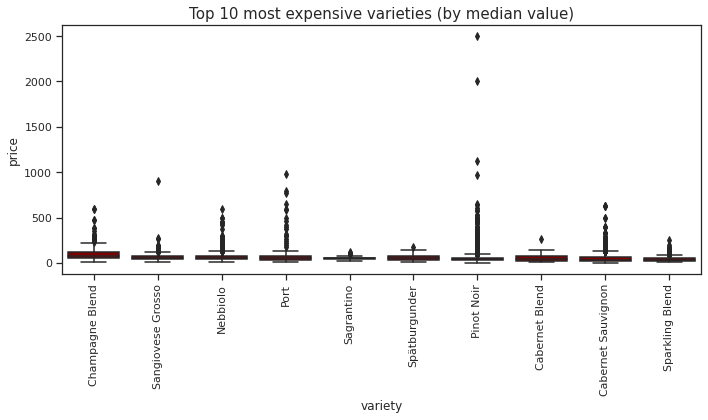

In [31]:
# Plot top 10 most expensive

# Filter top 10
exp_var = list(wine_exp[0:10].index)
wine_df_exp = wine_df[wine_df['variety'].isin(exp_var)]

# Order by median
wine_exp_sort = wine_df_exp.groupby(['variety'])['price'].describe().sort_values('50%',
                                                                          ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', 
               x='variety',
               data=wine_df_exp,
               order=wine_exp_sort.index,
               color=my_col,
               saturation=1)
plt.title('Top 10 most expensive varieties (by median value)', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

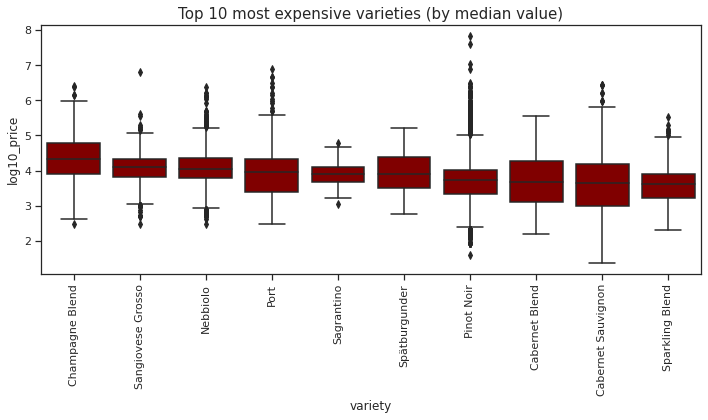

In [32]:
# Plot top 10 most expensive - Log10 price

# Filter top 10
exp_var = list(wine_exp[0:10].index)
wine_df_exp = wine_df[wine_df['variety'].isin(exp_var)]

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(y='log10_price', 
            x='variety',
            data=wine_df_exp,
            order=wine_exp_sort.index,
            color=my_col,
            saturation=1)
plt.title('Top 10 most expensive varieties (by median value)', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

### Rating stats

In [33]:
# Wine rates by country - Filter the ones with at least 50 reviews
wine_by_country = wine_df.groupby(['country'])['points'].describe()
wine_by_country_10_sort = wine_by_country[wine_by_country['count'] >= 50].sort_values('50%',
                                                                          ascending=False)
wine_by_country_10_sort

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,2327.0,90.272454,2.496710,82.0,89.00,90.0,92.0,97.0
Canada,211.0,89.312796,2.464370,82.0,88.00,90.0,91.0,94.0
Germany,1828.0,89.997265,2.474278,81.0,88.00,90.0,92.0,98.0
Slovenia,57.0,88.157895,1.719525,82.0,87.00,89.0,89.0,92.0
Bulgaria,114.0,88.052632,1.899428,82.0,87.00,89.0,89.0,91.0
France,14218.0,88.755803,3.120904,80.0,86.00,89.0,91.0,100.0
Israel,422.0,88.450237,2.542959,80.0,86.00,89.0,90.0,94.0
Australia,1975.0,88.553418,2.976275,80.0,87.00,89.0,91.0,99.0
Italy,13784.0,88.798897,2.707761,80.0,87.00,88.0,90.0,100.0


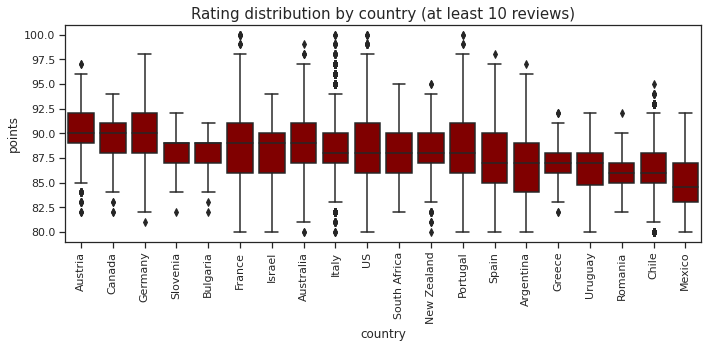

In [34]:
# Wine ratings by country
plt.figure(figsize=(10, 5))
sns.boxplot(y='points', 
               x='country',
               data=wine_df,
               order=wine_by_country_10_sort.index,
               color='maroon',
               #jitter=0.2,
               #linewidth=0.5,
               #alpha=0.5
               saturation=1
             )
plt.title('Rating distribution by country (at least 10 reviews)', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

### Price vs. Rating correlation

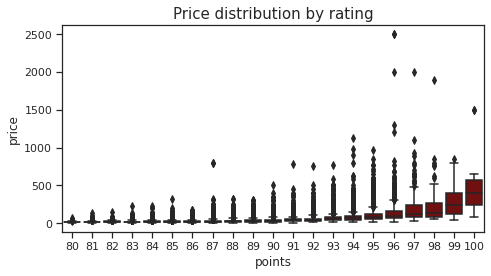

In [35]:
# Wine ratings by country
plt.figure(figsize=(7, 4))

sns.boxplot(y='price', 
            x='points',
            data=wine_df,
            color='maroon'
           )
plt.title('Price distribution by rating', fontsize=15)
plt.tight_layout()

In [36]:
# Calculate Kendall correlation between wine price and rating
from scipy.stats import kendalltau

corr_k, pval_k = kendalltau(wine_df['price'], wine_df['points'])
print(f'Pearson r={corr_k}, pval={pval_k}')

Pearson r=0.4601161964840996, pval=0.0


### Price vs. Vintage correlation

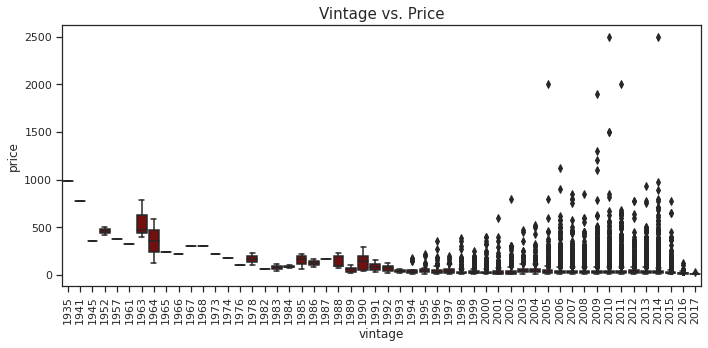

In [40]:
# Wine price by vintage
plt.figure(figsize=(10, 5))
sns.boxplot(y='price', 
            x='vintage',
            data=wine_df,
            color='maroon',
            orient='v'
           )
plt.title('Vintage vs. Price', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [41]:
# Calculate Kendall correlation between wine price and vintage

corr_k, pval_k = kendalltau(wine_df['price'], wine_df['vintage'])
print(f'Kendall tau={corr_k}, pval={pval_k}')

Kendall tau=-0.08162649813083059, pval=2.1344013571369916e-302


### Rating vs. Vintage correlation

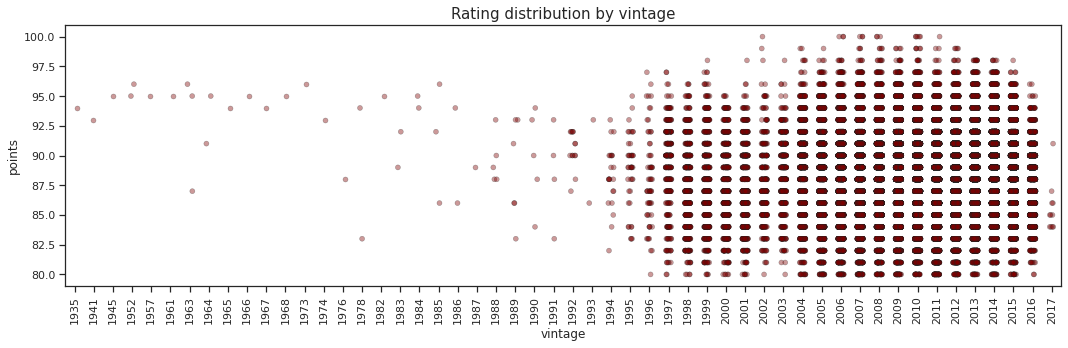

In [42]:
# Wine ratings by vintage
plt.figure(figsize=(15, 5))
sns.stripplot(y='points', 
            x='vintage',
            data=wine_df,
            color='maroon',
            jitter=0.15,
            linewidth=0.5,
            alpha=0.4
           )
plt.title('Rating distribution by vintage', fontsize=15)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [39]:
# Calculate Kendall correlation between wine rating and vintage
corr_k, pval_k = kendalltau(wine_df['points'], wine_df['vintage'])
print(f'Kendall tau={corr_k}, pval={pval_k}')

Kendall tau=0.05230430415164576, pval=3.2445330236841995e-118


### 'Hidden gems': high rating and low price

In [40]:
# Hidden gems
top_95 = wine_df[wine_df['points']>=95]
top_95_cheap = top_95[top_95['price']<=30]
top_95_cheap.groupby(['title']).aggregate(np.mean).reset_index().sort_values('price', ascending=True)

,title,points,price,vintage,log10_price
1,Alain Brumont 2010 Château Bouscassé Red (Madi...,95,20.0,2010,2.995732
15,Dunham 2010 Lewis Estate Vineyard Riesling (Co...,95,20.0,2010,2.995732
22,Januik 2012 Bacchus Vineyard Riesling (Columbi...,95,20.0,2012,2.995732
29,Poet's Leap 2009 Riesling (Columbia Valley (WA)),95,20.0,2009,2.995732
31,Rulo 2007 Syrah (Columbia Valley (WA)),96,20.0,2007,2.995732
16,EOS 2006 Tears of Dew Late Harvest Moscato (Pa...,95,22.0,2006,3.091042
25,La Clarine Farm 2011 Cedarville Mourvèdre (Sie...,95,24.0,2011,3.178054
32,Sineann 2013 Riesling (Oregon),95,24.0,2013,3.178054
26,McCrea 2008 Boushey Vineyard Sirocco Blanc Whi...,95,25.0,2008,3.218876
23,Julien Schaal 2016 Kastelberg Grand Cru Schist...,95,25.0,2016,3.218876


In [41]:
# Hidden gems
top_99 = wine_df[wine_df['points']>=98]
top_99_cheap = top_99[top_99['price']<=50]
top_99_cheap.groupby(['title']).aggregate(np.mean).reset_index().sort_values('price', ascending=True)

,title,points,price,vintage,log10_price
0,Failla 2010 Estate Vineyard Chardonnay (Sonoma...,99,44.0,2010,3.784190
1,Pirouette 2008 Red Wine Red (Columbia Valley (...,98,50.0,2008,3.912023


## Step3: NLP

In [42]:
# Start by subselecting varietal wines
# 18 'Noble grapes': https://winefolly.com/lifestyle/the-18-noble-grapes-wine-challenge/

red_noble = [
    'Pinot Noir',
    'Grenache',
    'Merlot',
    'Sangiovese',
    'Nebbiolo',
    'Tempranillo',
    'Cabernet Sauvignon',
    'Syrah',
    'Malbec'
]

white_noble = [
    'Pinot Grigio',
    'Riesling',
    'Sauvignon Blanc',
    'Chenin Blanc',
    'Muscat',
    'Gewürztraminer',
    'Sémillon',
    'Viognier',
    'Chardonnay'
]

In [43]:
# Create new dataframe with varietals only
wine_df_var = wine_df[wine_df['variety'].isin(red_noble+white_noble)].reset_index(drop=True)
wine_df_var.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,log10_price
0,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Grigio,Rainstorm,2013,2.639057
1,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,2.564949
2,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,4.174387
3,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012,3.178054
4,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013,2.484907


In [44]:
# Create normalized review corpus
# Normalize text in each sentence: tokenize, lemmatize, remove punctuation and stopwords

# Set of stopwords
stop_words = set(stopwords.words('english')) 
stopwords_to_add = [
    "drink","taste","like","offer","wine", 
    "flavor","flavors","palate","finish", "aroma",
    "aromas","nose","notes","note","show",
    "pinot","noir","cabernet", "sauvignon","blanc",
    "grigio","chenin","shiraz","barolo","petit", 
    "verdot","franc","grape","style"] + [wine.lower() for wine in white_noble] + [wine.lower() for wine in red_noble]
 
# Update stopwords    
stop_words.update(stopwords_to_add)

# Instantiate lemmatization model
lemma = nltk.wordnet.WordNetLemmatizer()

# Define function to normalize reviews
def get_normalization(input_text, stop_words):
    normalized_words_list = []
    # Tokenize by word
    word_list = word_tokenize(input_text)
    for word in word_list:
        # Convert to string
        word = str(word)
        # Lower case
        lower_case_word = str.lower(word)
        # Lemmatize
        lemma_word = lemma.lemmatize(lower_case_word)
        # Exclude punctuation and stopwords
        punctuation_dict = str.maketrans({punct: None for punct in string.punctuation})
        exclude_punctuation = lemma_word.translate(punctuation_dict)
        if len(exclude_punctuation) > 1 and exclude_punctuation not in stop_words:
            normalized_words_list.append(exclude_punctuation)
    return normalized_words_list

# Define function to apply normalization to all reviews
def get_normalized_reviews(reviews, stop_words):
    reviews_list = list(reviews)
    norm_reviews = []
    for review in reviews_list:
        norm_review = get_normalization(review, stop_words)
        norm_reviews.append(norm_review)
    return norm_reviews

In [45]:
# Normalize reviews
normalized_reviews = get_normalized_reviews(wine_df_var['description'], stop_words)
normalized_reviews[0]

['tart',
 'snappy',
 'lime',
 'flesh',
 'rind',
 'dominate',
 'green',
 'pineapple',
 'poke',
 'crisp',
 'acidity',
 'underscoring',
 'wa',
 'stainlesssteel',
 'fermented']

In [46]:
wine_df_var['description'].loc[0]

'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.'

In [47]:
# Get ngrams
def get_ngrams(reviews_norm, min_count_par=50):
    # Phrases() takes a list of list of words as input
    # Create relevant phrases from the list of sentences:
    phrases = Phrases(normalized_reviews, min_count=min_count_par)
    # Transform corpus based on detected bigrams:
    bigrams = Phraser(phrases)
    ngrams_sents = []
    for sent in normalized_reviews:
        ngrams_sent = bigrams[sent]
        ngrams_sents.append(ngrams_sent)
    return ngrams_sents

ngrams_sentences = get_ngrams(normalized_reviews, 20)
ngrams_words = [word for sub_sent in ngrams_sentences for word in sub_sent]
ngrams_words[0:50]

['tart',
 'snappy',
 'lime',
 'flesh',
 'rind',
 'dominate',
 'green',
 'pineapple',
 'poke',
 'crisp',
 'acidity',
 'underscoring',
 'wa',
 'stainlesssteel_fermented',
 'pineapple',
 'rind',
 'lemon_pith',
 'orange_blossom',
 'start',
 'bit',
 'opulent',
 'honeydrizzled',
 'guava',
 'mango',
 'giving',
 'way',
 'slightly',
 'astringent',
 'semidry',
 'much',
 'regular_bottling',
 '2012',
 'come_across',
 'rather',
 'rough',
 'tannic',
 'rustic',
 'earthy',
 'herbal',
 'characteristic',
 'nonetheless',
 'think',
 'pleasantly',
 'unfussy',
 'country',
 'good',
 'companion',
 'hearty',
 'winter',
 'stew']

In [48]:
# Add column with normalized reviews
wine_df_var['norm_description'] = ngrams_sentences
wine_df_var.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,log10_price,norm_description
0,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Grigio,Rainstorm,2013,2.639057,"[tart, snappy, lime, flesh, rind, dominate, gr..."
1,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,2.564949,"[pineapple, rind, lemon_pith, orange_blossom, ..."
2,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,4.174387,"[much, regular_bottling, 2012, come_across, ra..."
3,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012,3.178054,"[dry, restrained, spice, profusion, balanced, ..."
4,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013,2.484907,"[savory, dried, thyme, accent, sunnier, preser..."


In [49]:
# Import wheel terms
# Reference for aroma terms: https://winefolly.com/tips/wine-aroma-wheel-100-flavors/
# Reference for structure terms: https://winefolly.com/deep-dive/blind-wine-tasting-grid-pdf/
standardized_wheel_desc = pd.read_csv('/data/ids_wheel.txt')
standardized_wheel_desc.head()

,std_desc
0,iris
1,peony
2,elderflower
3,acacia
4,lilac


In [50]:
# Map ngrams to standardized terms
def get_descriptor_mapping(descriptor):
    if descriptor in list(standardized_wheel_desc['std_desc']):
        normalized_desc = descriptor
        return normalized_desc
    else:
        return 'NaN'

def get_standardized_reviews(phrased_sentences):    
    normalized_sentences = []
    for sent in phrased_sentences:
        normalized_sentence = []
        for word in sent:
            normalized_word = get_descriptor_mapping(word)
            if normalized_word is not 'NaN' and normalized_word not in normalized_sentence:
                normalized_sentence.append(str(normalized_word))
        normalized_sentences.append(normalized_sentence)
    return normalized_sentences

In [51]:
# Get standardized reviews
std_reviews = get_standardized_reviews(wine_df_var['norm_description'])
std_reviews[0:10]

[['lime', 'pineapple'],
 ['pineapple', 'guava', 'mango'],
 [],
 ['dry', 'spice', 'balanced'],
 ['savory', 'thyme', 'peach'],
 ['spice', 'dry', 'balanced'],
 ['plum', 'coffee'],
 ['dry', 'mineral'],
 ['black_cherry', 'oak', 'cigar_box'],
 ['pear', 'pineapple']]

In [52]:
# Add standardized reviews to dataFrame
wine_df_var['std_review'] = std_reviews
wine_df_var.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage,log10_price,norm_description,std_review
0,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Grigio,Rainstorm,2013,2.639057,"[tart, snappy, lime, flesh, rind, dominate, gr...","[lime, pineapple]"
1,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,2.564949,"[pineapple, rind, lemon_pith, orange_blossom, ...","[pineapple, guava, mango]"
2,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,4.174387,"[much, regular_bottling, 2012, come_across, ra...",[]
3,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012,3.178054,"[dry, restrained, spice, profusion, balanced, ...","[dry, spice, balanced]"
4,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel,2013,2.484907,"[savory, dried, thyme, accent, sunnier, preser...","[savory, thyme, peach]"


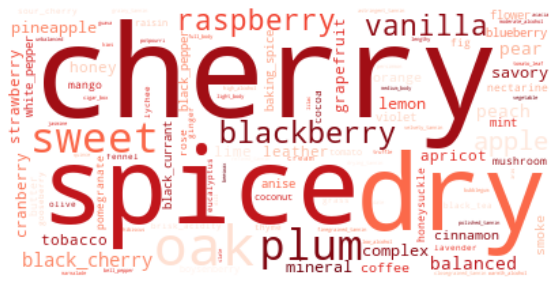

In [62]:
# Format to plot word cloud
full_list = [string for word in wine_df_var['std_review'] for string in word]
text_to_word_cloud = ' '.join(full_list)

# Plot word cloud
wordcloud = WordCloud(background_color="white", 
                      max_words=200,
                      collocations = False,
                      colormap='Reds')
wordcloud.generate(text_to_word_cloud)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, 
           interpolation='bilinear')
plt.axis("off")
plt.show()

In [54]:
# Total number of features
len(set(full_list))

110

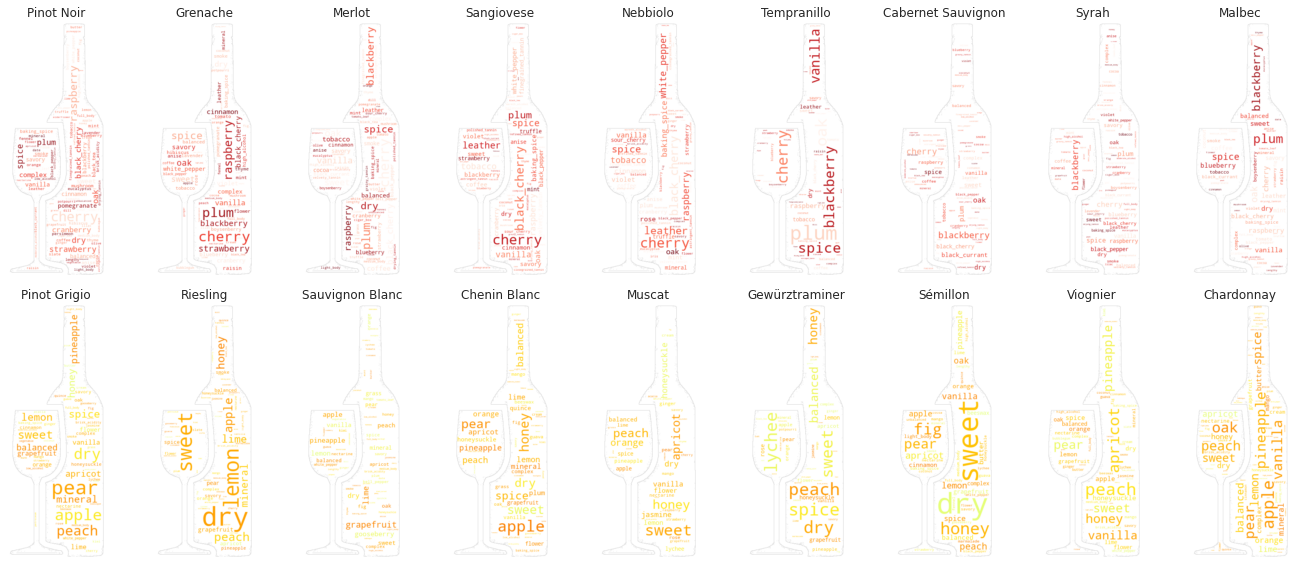

In [55]:
# Create wordcloud by wine variety

# Import an image to build a mask
wine_mask = np.array(Image.open("/images/wine-bottle-glass.png"))

# Format wine_mask to match wordclouds format (0 should be 255):
wine_mask_form = np.where(wine_mask>0, 255, wine_mask)

# Plot wordclouds    
plt.figure(figsize=(19,8))
for i, wine in enumerate(red_noble + white_noble):
    wine_ls = [string for word in wine_df_var[wine_df_var['variety']==wine].std_review for string in word]
    wine_to_plot = ' '.join(wine_ls)
    
    # Select color red or white wine
    if wine in red_noble:
        colm = 'Reds'
    else:
        colm = 'Wistia'
    
    # Wordcloud config
    wordcloud = WordCloud(background_color="white",
                          max_words=200,
                          collocations=False,
                          colormap=colm,
                          mask=wine_mask_form,
                          contour_color='lightgrey',
                          contour_width=0.001)
    
    # Generate wordcloud
    wordcloud.generate(wine_to_plot)    
    plt.subplot(2,9,i+1)
    plt.imshow(wordcloud, 
               interpolation='bilinear')
    plt.axis("off")
    plt.title(wine, fontsize=12)

plt.show()
plt.tight_layout()
#plt.savefig('wordclouds_plot.pdf', dpi=1000)  

In [56]:
# Filter the wines with more than 5 descriptors
wine_df_var_filt = wine_df_var.copy()
wine_df_var_filt = wine_df_var_filt[wine_df_var_filt['std_review'].apply(lambda x: len(x) >= 5)]
wine_df_var_filt.shape

(5057, 17)

In [57]:
# Create multilabel binarizer
mlb = MultiLabelBinarizer()
mlb_encoded_results = mlb.fit_transform(wine_df_var_filt['std_review'])
# Classes created in MultiLabel data after Encoding
mlb.classes_

array(['acacia', 'anise', 'apple', 'apricot', 'astringent_tannin',
       'baking_spice', 'balanced', 'beeswax', 'bell_pepper',
       'black_cherry', 'black_currant', 'black_pepper', 'black_tea',
       'blackberry', 'blueberry', 'boysenberry', 'brisk_acidity',
       'bubblegum', 'butter', 'cherry', 'cigar_box', 'cinnamon',
       'closegrained_tannin', 'cocoa', 'coconut', 'coffee', 'complex',
       'cranberry', 'cream', 'date', 'dill', 'dry', 'drying_tannin',
       'elderflower', 'eucalyptus', 'fennel', 'fig', 'finegrained_tannin',
       'flower', 'fruitcake', 'full_body', 'ginger', 'gooseberry',
       'grainy_tannin', 'grapefruit', 'grass', 'guava', 'hibiscus',
       'high_alcohol', 'honey', 'honeysuckle', 'iris', 'jasmine', 'kiwi',
       'lavender', 'leather', 'lemon', 'lengthy', 'light_body', 'lilac',
       'lime', 'low_alcohol', 'lychee', 'mango', 'marmalade',
       'medium_body', 'mineral', 'mint', 'moderate_alcohol', 'mushroom',
       'nectarine', 'oak', 'olive', 'ora

In [58]:
# Converting an Numpy Array into a pandas dataframe
wine_df_var_filt_mlb = pd.DataFrame(mlb_encoded_results, columns=mlb.classes_)
# Viewing few rows of data
wine_df_var_filt_mlb.index = wine_df_var_filt['title']
wine_df_var_filt_mlb.head(n=10)

,acacia,anise,apple,apricot,astringent_tannin,baking_spice,balanced,beeswax,bell_pepper,black_cherry,...,tomato,tomato_leaf,truffle,unbalanced,vanilla,vegetable,velvety_tannin,violet,warmth_alcohol,white_pepper
title,,,,,,,,,,,,,,,,,,,,,
Kuentz-Bas 2007 Cuvée Jerémy Sélection de Grains Nobles Pinot Gris (Alsace),0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Domaine Zind-Humbrecht 2007 Hunawihr Clos Windsbuhl Pinot Gris (Alsace),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vincent Vineyards 2012 Family Reserve Cabernet Sauvignon (Santa Ynez Valley),0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Albatross Ridge 2012 Estate Reserve Pinot Noir (Carmel Valley),0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Big Basin 2013 Syrah (Santa Cruz Mountains),0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Castello di Gabbiano 2012 Bellezza Gran Selezione (Chianti Classico),0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Claiborne & Churchill 2014 Claiborne Vineyard Riesling (Edna Valley),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G7 2012 The 7th Generation Gran Reserva Estate Bottled Cabernet Sauvignon (Loncomilla Valley),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Yatir 2011 Syrah (Judean Hills),0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Step4: Recommendation

In [59]:
# Add price and rating to data frame to filter later
wine_df_var_filt_mlb['price'] = wine_df_var_filt['price'].values
wine_df_var_filt_mlb['rating'] = wine_df_var_filt['points'].values

In [60]:
# Instantiate knn model
knn = NearestNeighbors(n_neighbors=5,
                       algorithm='brute', 
                       metric='cosine')

In [61]:
# Get wine recommendations
def get_recommendations(input_df=wine_df_var_filt_mlb, 
                        wine_idx=None, 
                        max_price=1000000, 
                        min_rate=80):
    
    # Filter data based on max price and min rating
    df_mlb_filt = input_df.loc[(input_df['price'] < max_price) & 
                               (input_df['rating'] >= min_rate)]
    try:
        if df_mlb_filt.shape[0] > 1:
    
            # Select a wine randomly if none is provided
            if wine_idx is None:
                query_index = np.random.choice(df_mlb_filt.shape[0])
            
            # Use input wine name to get index
            else:
                wine_name = df_mlb_filt.index == wine_idx
                query_index = [int(idx) for idx in wine_name.nonzero()][0]
    
            # Fit knn model
            model_knn = knn.fit(df_mlb_filt.iloc[:,:-2])
    
            # Get distances and indexes from the top 5 neighbors
            distance, index_neigh = model_knn.kneighbors(df_mlb_filt.iloc[query_index,:-2].values.reshape(1,-1), 
                                                         n_neighbors=6)
    
            # Return top 5 recommendations
            for i in range(0, len(distance.flatten())):
                if  i == 0:
                    print(f'Top 5 recommendations for: \n{df_mlb_filt.index[query_index]} | Price: ${df_mlb_filt.price[query_index]} | Rating: {df_mlb_filt.rating[query_index]} \n')
                else:
                    print(f'#{i}: {df_mlb_filt.index[index_neigh.flatten()[i]]} | (Distance: {round(distance.flatten()[i], 4)}) \nPrice: ${df_mlb_filt.price[index_neigh.flatten()[i]]} | Rating: {df_mlb_filt.rating[index_neigh.flatten()[i]]}\n')
    except:
        raise Exception('0 recommendations avaiable. \nTry to increase maximum price and/or decrease minimum rate.')

In [142]:
# Run query
# Get top 5 recommendations for a random wine
get_recommendations(input_df=wine_df_var_filt_mlb)

Top 5 recommendations for: 
Cederberg 2010 Sauvignon Blanc (Cederberg) | Price: $22.0 | Rating: 88 

#1: Spier 2016 Vintage Selection Sauvignon Blanc (Coastal Region) | (Distance: 0.2) 
Price: $17.0 | Rating: 90

#2: Robert Weil 2015 Kiedrich Gräfenberg Auslese Riesling (Rheingau) | (Distance: 0.2697) 
Price: $182.0 | Rating: 95

#3: Diatom 2016 Machado Chardonnay (Sta. Rita Hills) | (Distance: 0.4) 
Price: $42.0 | Rating: 92

#4: Mulderbosch 2011 Chenin Blanc (Western Cape) | (Distance: 0.4) 
Price: $15.0 | Rating: 88

#5: Joh. Jos. Prüm 2011 Graacher Himmelreich Auslese GoldKap Riesling (Mosel) | (Distance: 0.4) 
Price: $107.0 | Rating: 95



In [140]:
# Get top 5 for a specific wine with filtering by price and rating
get_recommendations(input_df=wine_df_var_filt_mlb,
                    wine_idx="Kuentz-Bas 2007 Cuvée Jerémy Sélection de Grains Nobles Pinot Gris (Alsace)",
                    max_price=150, 
                    min_rate=90)

Top 5 recommendations for: 
Kuentz-Bas 2007 Cuvée Jerémy Sélection de Grains Nobles Pinot Gris (Alsace) | Price: $112.0 | Rating: 90 

#1: Maximin Grünhäuser 2014 Feinherb Riesling (Mosel) | (Distance: 0.2697) 
Price: $22.0 | Rating: 90

#2: Dr. H. Thanisch (Erben Müller-Burggraef) 2012 Berncasteler Doctor Spatlëse Riesling (Mosel) | (Distance: 0.3333) 
Price: $58.0 | Rating: 91

#3: Castello di Amorosa 2013 Late Harvest Gewurztraminer (Anderson Valley) | (Distance: 0.3333) 
Price: $39.0 | Rating: 92

#4: Staatliche Weinbaudomäne Trier 2012 Avelsbacher Hammerstein Riesling (Mosel) | (Distance: 0.3828) 
Price: $23.0 | Rating: 90

#5: Staatliche Weinbaudomäne Oppenheim 2015 Herrenberg Auslese Riesling (Rheinhessen) | (Distance: 0.3828) 
Price: $27.0 | Rating: 91



In [ ]:
# TF-IDF

def get_formated_reviews_tfidf(input_std_reviews):
    form_reviews = []
    for review in input_std_reviews:
        form_review = ' '.join(review)\n
        form_reviews.append(form_review)
    return form_reviews

reviews_tfidf = get_formated_reviews_tfidf(wine_df_var_filt['std_review'])

vectorizer = TfidfVectorizer()
vectorizer_fit = vectorizer.fit(reviews_tfidf)